# Simulating a microgenerator device

First, we'll need the necessary imports:

## Background
<img src='./_img/mcrg.png' width=600px></img>

In `FFS`, we can simulate and optimize energy harvesters that have the same architecture and basic properties as shown above.
Namely, the energy harvester must be a single-axis, cylindrical microgenerators that consist of one or more evenly-spaced coils wound around the outside of the body.
Inside the body is a moving magnet assembly, suspended by a magnetic spring, that consists of one or more evenly-spaced magnets.

We simulate these devices by composing a number of "submodels" together, each representing parts of the mechanical system, the electrical system or the interaction between these two systems. This means we'll need to specify a number of different components:

- The magnet assembly
- The coil(s)
- The flux curve model
- The mechanical friction
- The electro-mechanical damping (coupling) force
- The magnetic spring behaviour
- The target load
- The impact dynamics
- The input excitation
- The device height
- The behavioural system model

This may seem a bit daunting at first-glance, but fortunately `FFS` has been designed to make defining and simulating these devices as painless as possible. Let's dive in.

## Defining a base microgenerator model
Let's start by first creating a base microgenerator model, without any components or submodels attached to it.
First, we'll have to import `FFS`:

In [16]:
import ffs

We define all models using the `UnifiedModel` class from the `unified` module:

In [17]:
model = ffs.unified.UnifiedModel()

Due to the iterative and exploratory nature of energy harvester design, `FFS` makes it easy to inspect its various components.
We can `print` most components to get an overview of their properties:

In [19]:
print(model)  # Print our base model

Unified Model: 
  height: None
  governing_equations: None
  time: None
  raw_solution: None
  post_processing_pipeline: {}
  magnetic_spring: None
  magnet_assembly: None
  mechanical_spring: None
  mechanical_damper: None
  input_excitation: None
  flux_model: None
  coil_configuration: None
  rectification_drop: None
  load_model: None
  coupling_model: None
  extra_components: {}
  _observers: {}


## Adding properties and components

Right now, we can see that our `model` is completely empty -- no components are currently attached to it.
We can attach submodels and propererties to our model using the `.with_*` methods. Let's go ahead and set the height of our microgenerator:

In [7]:
model.with_height(105 / 1000)  # Must be in metres!

If we print our model again, we'll see that we've now attached the `height` property:

In [8]:
print(model)

Unified Model: 
  height: 0.105
  governing_equations: None
  time: None
  raw_solution: None
  post_processing_pipeline: {}
  magnetic_spring: None
  magnet_assembly: None
  mechanical_spring: None
  mechanical_damper: None
  input_excitation: None
  flux_model: None
  coil_configuration: None
  rectification_drop: None
  load_model: None
  coupling_model: None
  extra_components: {}
  _observers: {}


Now, let's create a magnet assembly that we can attach to our `model`:

In [11]:
magnet_assembly = mechanical_components.magnet_assembly.MagnetAssembly(
    m=1,  # Number of magnets
    l_m_mm=10,  # Magnet length
    l_mcd_mm=0,  # Spacing between magnets (not relevant to this example)
    dia_magnet_mm=10,  # Magnet diameter
    dia_spacer_mm=0  # Spacer diamer (also not relevant here)
)

MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=0)


The magnet assembly is considered a mechanical component.
As a result, it is made available in the `ffs.mechanical_components` module.
Like with most things in `ffs`, we can also print the `magnet_assembly` to see all of its properties:

In [13]:
print(magnet_assembly)

MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=0)


All that's left to do is attach it to our `model`:

In [14]:
model.with_magnet_assembly(magnet_assembly)
print(model)

Unified Model: 
  height: 0.105
  governing_equations: None
  time: None
  raw_solution: None
  post_processing_pipeline: {}
  magnetic_spring: None
  magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=0)
  mechanical_spring: None
  mechanical_damper: None
  input_excitation: None
  flux_model: None
  coil_configuration: None
  rectification_drop: None
  load_model: None
  coupling_model: None
  extra_components: {}
  _observers: {}


In [14]:
coil_configuration = ec.coil.CoilConfiguration(
    c=1,
    n_z=10,
    n_w=20,
    l_ccd_mm=15,
    ohm_per_mm=1079 / 1000 / 1000,
    coil_wire_radius_mm=0.143 / 2,
    coil_center_mm=50,
    inner_tube_radius_mm=5.5,
    tube_wall_thickness_mm=2
)

mechanical_damper = mc.damper.MassProportionalDamper(
    damping_coefficient=4.272,
    magnet_assembly=magnet_assembly
)

mechanical_spring = mc.mechanical_spring.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    damping_coefficient=3.108
)

magnetic_spring = mc.magnetic_spring.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_assembly=magnet_assembly
)

coupling = CouplingModel(
    coupling_constant=5.096
)

flux_model = ec.flux.model.FluxModelPretrained(
    coil_configuration=coil_configuration,
    magnet_assembly=magnet_assembly,
    curve_model_path='../data/flux_curve_model/flux_curve_model_2021_05_11.model'
)

load_model = ec.load.SimpleLoad(R=30)

# Put it all together
model = (
    UnifiedModel()
    .with_height(120 / 1000)
    .with_magnet_assembly(magnet_assembly)
    .with_coil_configuration(coil_configuration)
    .with_magnetic_spring(magnetic_spring)
    .with_mechanical_damper(mechanical_damper)
    .with_mechanical_spring(mechanical_spring)
    .with_rectification_drop(0.01)
    .with_coupling_model(coupling)
    .with_flux_model(flux_model)
    .with_load_model(load_model)
    .with_governing_equations(unified_ode)
)

In [15]:
model.summarize()


  ┌────┐         120
  │    │         115
  │    │         110
  │    │         105
  │    │         100
  │    │         95
  │    │         90
  │    │         85
  │    │         80
  │    │         75
┌─│████│─┐       70
└─│████│─┘       65
  │    │         60
  │    │         55
  │    │         50
  │    │         45
  │    │         40
  │    │         35
  │    │         30
  │    │         25
  │    │         20
  │    │         15
  │████│         10
  │████│         5
  └────┘         0
🧲 The magnet assembly consists of 1 magnet(s) that are 10mm long and have a diameter of 10mm.
🧲 The magnets' centers are 15mm apart.
🧲 The magnet assembly has a weight of 0.0578N.
🧲 The magnet assembly hovers 46.015mm above the fixed magnet.
-----------
⚡ There are 1 coils, each with 200 windings (10 vertical X 20 horizontal).
⚡ This gives each a coil an estimated height of ~1.43mm and width of ~2.86mm.
⚡ The coils' centers are 15mm apart.
⚡ The first coil's center is 50mm above the fixed ma

In [16]:
# Let's add an input excitation
from unified_model.utils.utils import collect_samples

samples = collect_samples(
    base_path='../data/2019-05-23/A/',
    acc_pattern='*acc*.csv',
    adc_pattern='*adc*.csv',
    video_label_pattern='*label*.csv'
)

first_sample = samples[0]

input_excitation = mc.input_excitation.accelerometer.AccelerometerInput(
    raw_accelerometer_data_path=first_sample.acc_path,
    accel_column='z_G',
    time_column='time(ms)',
    accel_unit='g',
    time_unit='ms'
)

# Attach it to our model
model = model.with_input_excitation(input_excitation)

In [18]:
# Run the simulation
model.solve(
    t_start=0,
    t_end=8,
    y0=[0., 0., 0.04, 0., 0.],  # initial conditions
    t_eval=np.linspace(0, 8, 1000),
    t_max_step=1e-3
)

In [25]:
results = model.get_result(time='t', y_diff='x3-x1', v_load='g(t, x5)')
results.head()

,time,y_diff,v_load
0,0.000000,0.040000,0.003102
1,0.008008,0.040164,0.011067
2,0.016016,0.040623,0.027823
3,0.024024,0.041307,0.045254
4,0.032032,0.042130,0.061065


<AxesSubplot:xlabel='time'>

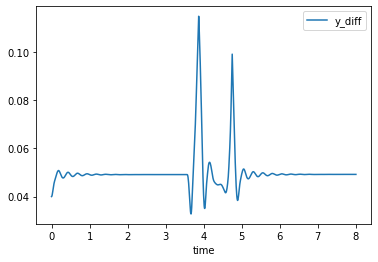

In [23]:
results.plot(x='time', y='y_diff')

<AxesSubplot:xlabel='time'>

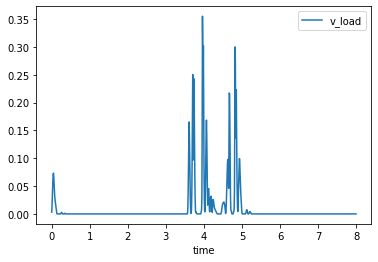

In [27]:
results.plot(x='time', y='v_load')